# Notebook 03: Inverse design parameterization

This notebook will introduce a few basic parameterization concepts for inverse design. The same mode converter device concept as in the previous notebook will be used here as an example.

*Parameterization* refers to how we are representing our device. In the previous notebook, we simply used a 2D array of permittivity values, $\epsilon_r[x,y]$.
However, we observed that this led to continuously varying features, which is not ideal for fabricating devices generated by our optimization. 
In this notebook, we will use a modified parameterization of the device to encourage more *binarized* features in the optimized device.
However, as we will see, we will still need to tune various hyperparameters in order to get desirable results.

We begin by importing the necessary python packages:

In [2]:
import numpy as np
import autograd.numpy as npa

import copy

import matplotlib as mpl
mpl.rcParams['figure.dpi']=100

import matplotlib.pylab as plt

from autograd.scipy.signal import convolve as conv
from skimage.draw import circle

import ceviche
from ceviche import fdfd_ez, fdfd_ez_nl, jacobian
from ceviche.optimizers import adam_optimize
from ceviche.utils import imarr, get_value
from ceviche.modes import insert_mode

import collections
# Create a container for our slice coords to be used for sources and probes
Slice = collections.namedtuple('Slice', 'x y')

## Introduction: device parameterization

Here, our device will be parameterized by a 2D array of density values (a density distribution, referred to as $\rho[x,y]$).
This part of the parameterization actually looks very similar to the 2D array of permitivitty values we used in the previous notebook. 
However, the difference is that we then definite two relatively simple operators that will be applied to this density. They are:

 - **Blur operator**: A 2D convolution blur filter with a configurable radius; can be applied a configurable number of times
 - **Projection operator**: A sigmoid-like nonlinear function for *binarizing* the output materials; has tunable slope and transition region

After these two operations are applied, the resulting density distribution, $\tilde{\rho}[x,y]$, will be a 2D array with values varying between `0.0` and `1.0`. A value of `0.0` represents a *background* material, while a value of `1.0` represents a *foreground* material.
The permitivitty distribution, which represents the optical description of our device, is then constructed as:
\begin{equation}
    \epsilon_r[x,y] = \epsilon_{\text{min}} + \left(\epsilon_{\text{max}} - \epsilon_{\text{min}} \right) \tilde{\rho}{[x,y]}
\end{equation}

We start by defining our parameterization operators:

In [3]:
# Projection that drives rho towards a "binarized" design with values either 0 or 1 
def operator_proj(rho, eta=0.5, beta=100):
    """Density projection
    eta     : Center of the projection between 0 and 1
    beta    : Strength of the projection
    """
    return npa.divide(npa.tanh(beta * eta) + npa.tanh(beta * (rho - eta)), 
                        npa.tanh(beta * eta) + npa.tanh(beta * (1 - eta)))

# Blurring filter that results in smooth features of the structure
def operator_blur(rho, radius=2, N=1):
    """Blur operator implemented via two-dimensional convolution
    radius    : Radius of the circle filter, higher radius -> smoother features
    """
    rr, cc = circle(radius, radius, radius+1)
    kernel = np.zeros((2*radius+1, 2*radius+1), dtype=np.float)
    kernel[rr, cc] = 1
    kernel=kernel/kernel.sum()
    
    for i in range(N):
        # For whatever reason HIPS autograd doesn't support 'same' mode, so we need to manually crop the output
        rho = conv(rho, kernel, mode='full')[radius:-radius,radius:-radius]
    
    return rho

### Visualization of the projection

Below we visualize the projection operator:

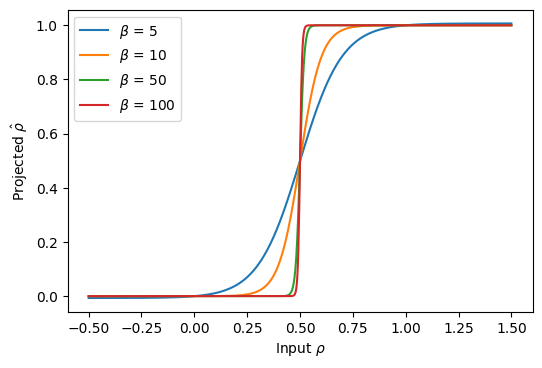

In [5]:
rho = np.linspace(-0.5, +1.5, 999)

# Visualize different values of the projection strength
plt.figure()
for beta in [5, 10, 50, 100]:
    plt.plot(rho, operator_proj(rho, beta=beta), label=r"$\beta$ = %d" % beta)

plt.xlabel(r"Input $\rho$")
plt.ylabel(r"Projected $\hat{\rho}$")
plt.legend()
plt.show()

### Visualization of the blur

Below we visualize the blur operator applied to a random 2D array:

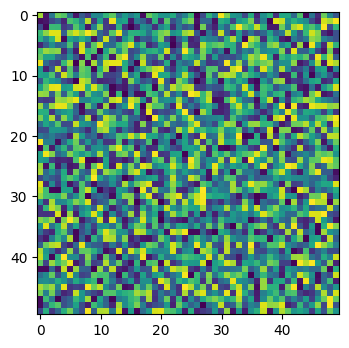

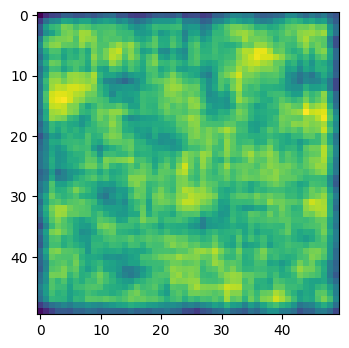

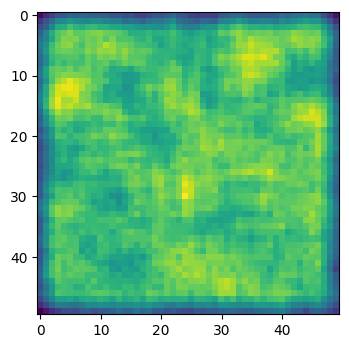

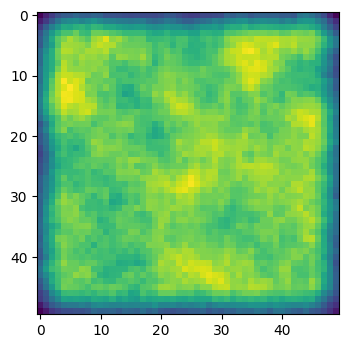

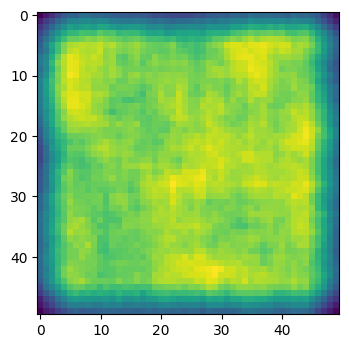

In [8]:
rho = np.random.rand(50, 50)

# Visualize different values of the blur radius
for radius in [None, 2, 3, 4, 5]:
    plt.figure()
    rho_p = operator_blur(rho, radius=radius, N=1) if radius is not None else rho
    plt.imshow(rho_p)
plt.show()

### Visualization of blur + projection

Finally, we visualize the combined projection and blur operation. Notice how the larger blur radius leads to larger and smoother features.

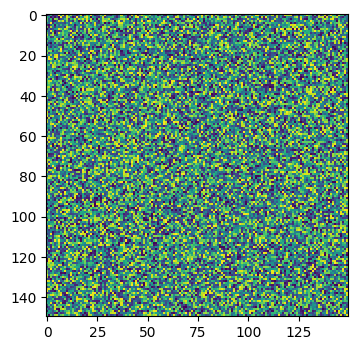

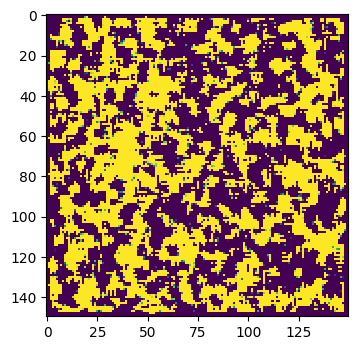

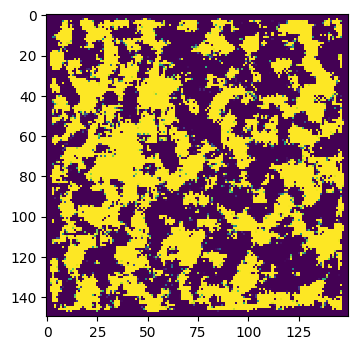

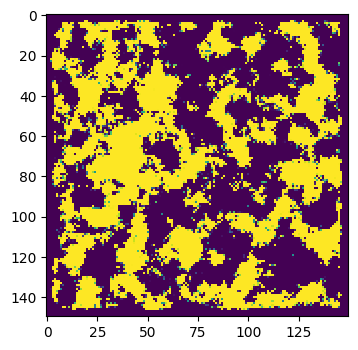

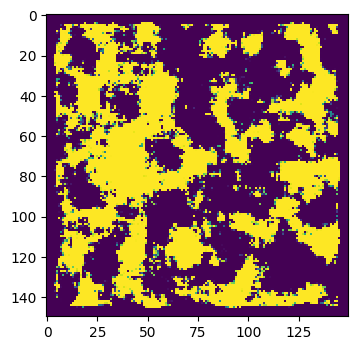

In [10]:
rho = np.random.rand(150, 150)

# Visualize different values of the blur radius
for radius in [None, 2, 3, 4, 5]:
    plt.figure()
    rho_p = operator_proj(operator_blur(rho, radius=radius, N=1), beta=500) if radius is not None else rho
    plt.imshow(rho_p)
plt.show()

## Helper functions

As in **Notebook 02**, here we define a helper function for constructing the simulation domain, feed waveguides, design region, input source, and output probe,

In [6]:
def init_domain(Nx, Ny, Npml, space=10, wg_width=10, space_slice=5):
    """Initializes the domain and design region

    space       : The space between the PML and the structure
    wg_width    : The feed and probe waveguide width
    space_slice : The added space for the probe and source slices
    """
    rho = np.zeros((Nx, Ny))  
    design_region = np.zeros((Nx, Ny))
    
    # Input waveguide
    rho[0:int(Npml+space),int(Ny/2-wg_width/2):int(Ny/2+wg_width/2)] = 1

    # Input probe slice
    input_slice = Slice(x=np.array(Npml+1), 
        y=np.arange(int(Ny/2-wg_width/2-space_slice), int(Ny/2+wg_width/2+space_slice)))
    
    # Output waveguide 
    rho[int(Nx-Npml-space)::,int(Ny/2-wg_width/2):int(Ny/2+wg_width/2)] = 1
    
    # Output probe slice
    output_slice = (Slice(x=np.array(Nx-Npml-1), 
        y=np.arange(int(Ny/2-wg_width/2-space_slice), int(Ny/2+wg_width/2+space_slice))))
    
    design_region[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space] = 1
    rho[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space] = 0.5
    
    bg_rho = copy.deepcopy(rho)

    return rho, bg_rho, design_region, input_slice, output_slice

def viz_sim(epsr):
    """Solve and visualize a simulation with permittivity 'epsr'
    """
    simulation = fdfd_ez(omega, dl, epsr, [Npml, Npml])
    Hx, Hy, Ez = simulation.solve(source)
    fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(6,3))
    ceviche.viz.real(Ez, outline=epsr, ax=ax[0], cbar=False)
    ax[0].plot(input_slice.x*np.ones(len(input_slice.y)), input_slice.y, 'g-')
    ax[0].plot(output_slice.x*np.ones(len(output_slice.y)), output_slice.y, 'r-')
    ceviche.viz.abs(epsr, ax=ax[1], cmap='Greys');
    plt.show()
    return (simulation, ax)

In [7]:
def mask_combine_rho(rho, bg_rho, design_region):
    """Utility function for combining the design region rho and the background rho
    """
    return rho*design_region + bg_rho*(design_region==0).astype(np.float)

def epsr_parameterization(rho, bg_rho, design_region, radius=2, blur_applications=1, beta=100, eta=0.5):
    """Defines the parameterization steps for constructing rho
    """
    # Combine rho and bg_rho; Note: this is so the subsequent blur sees the waveguides
    rho = mask_combine_rho(rho, bg_rho, design_region)
    
    rho = operator_blur(rho, radius=radius, N=blur_applications)
    rho = operator_proj(rho, beta=beta, eta=eta)
    
    # Final masking undoes the blurring of the waveguides
    rho = mask_combine_rho(rho, bg_rho, design_region)
    
    return epsr_min + (epsr_max-epsr_min) * rho

## Parameters
Feel free to explore what happens as you run the optimization with different parameters, especially `blur_radius` and `beta`.

In [11]:
# Number of epochs in the optimization 
Nsteps=30
# Step size for the Adam optimizer
step_size=1e-2
# Angular frequency of the source in 1/s
omega=2*np.pi*200e12
# Spatial resolution in meters
dl=40e-9
# Number of pixels in x-direction
Nx=120
# Number of pixels in y-direction
Ny=120
# Number of pixels in the PMLs in each direction
Npml=20
# Minimum value of the relative permittivity
epsr_min=1.0
# Maximum value of the relative permittivity
epsr_max=12.0
# Radius of the smoothening features
blur_radius=5
# Number of times to apply the smoothening
blur_applications=1
# Strength of the binarizing projection
beta=500.0
# Middle point of the binarizing projection
eta=0.5
# Space between the PMLs and the design region (in pixels)
space=default=10
# Width of the waveguide (in pixels)
wg_width=12
# Length in pixels of the source/probe slices on each side of the center point
space_slice=8

## Simulate the initial structure



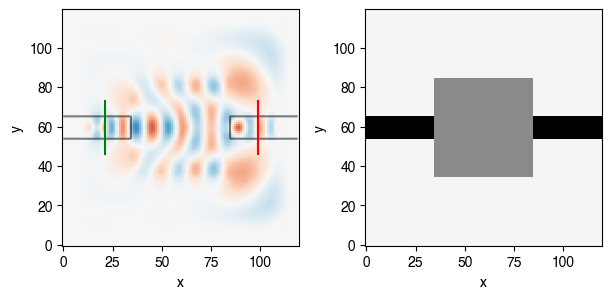

In [9]:
# Initialize the parametrization rho and the design region
rho, bg_rho, design_region, input_slice, output_slice = \
    init_domain(Nx, Ny, Npml, space=space, wg_width=wg_width, space_slice=space_slice)

# Compute the permittivity from rho_init, including blurring and projection
epsr_init = epsr_parameterization(rho, bg_rho, design_region, \
                                  radius=blur_radius, blur_applications=blur_applications, beta=beta, eta=eta)

# Setup source
source = insert_mode(omega, dl, input_slice.x, input_slice.y, epsr_init, m=1)

# Setup probe
probe = insert_mode(omega, dl, output_slice.x, output_slice.y, epsr_init, m=2)

# Simulate initial device
simulation, ax = viz_sim(epsr_init)

## Run the mode converter optimization

Epoch:   1/ 30 | Duration: 0.18 secs | Value: 1.129455e-13
Epoch:   2/ 30 | Duration: 0.16 secs | Value: 5.830047e-07
Epoch:   3/ 30 | Duration: 0.16 secs | Value: 9.620146e-07
Epoch:   4/ 30 | Duration: 0.15 secs | Value: 1.437582e-06
Epoch:   5/ 30 | Duration: 0.15 secs | Value: 1.405023e-06
Epoch:   6/ 30 | Duration: 0.15 secs | Value: 1.540342e-06
Epoch:   7/ 30 | Duration: 0.15 secs | Value: 1.648350e-06
Epoch:   8/ 30 | Duration: 0.15 secs | Value: 1.635590e-06
Epoch:   9/ 30 | Duration: 0.15 secs | Value: 1.643319e-06
Epoch:  10/ 30 | Duration: 0.15 secs | Value: 1.714150e-06
Epoch:  11/ 30 | Duration: 0.15 secs | Value: 1.819203e-06
Epoch:  12/ 30 | Duration: 0.15 secs | Value: 1.937944e-06
Epoch:  13/ 30 | Duration: 0.15 secs | Value: 2.028754e-06
Epoch:  14/ 30 | Duration: 0.15 secs | Value: 2.082247e-06
Epoch:  15/ 30 | Duration: 0.16 secs | Value: 2.160311e-06
Epoch:  16/ 30 | Duration: 0.15 secs | Value: 2.287093e-06
Epoch:  17/ 30 | Duration: 0.16 secs | Value: 2.374855e-

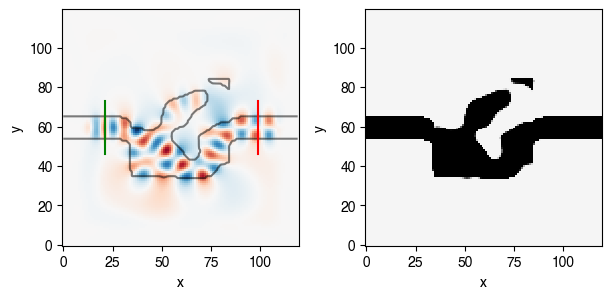

In [10]:
# Define optimization objective
def measure_modes(Ez):
    """Defines an overlap integral between the sim field and desired field
    """
    return npa.abs(npa.sum(npa.conj(Ez)*probe))

def objective(rho):
    """Objective function called by optimizer
    
    1) Takes the density distribution as input
    2) Constructs epsr
    2) Runs the simulation
    3) Returns the overlap integral between the output wg field 
       and the desired mode field
    """
    rho = rho.reshape((Nx, Ny))
    epsr = epsr_parameterization(rho, bg_rho, design_region, \
                             radius=blur_radius, blur_applications=blur_applications, beta=beta, eta=eta)
    simulation.eps_r = epsr
    _, _, Ez = simulation.solve(source)
    return measure_modes(Ez)

# Compute the gradient of the objective function using revere-mode differentiation
objective_jac = jacobian(objective, mode='reverse')

# Maximize the objective function using an ADAM optimizer
(rho_optimum, loss) = adam_optimize(objective, rho.flatten(), objective_jac,
                         Nsteps=Nsteps, direction='max', step_size=step_size)

# Simulate optimal device
rho_optimum = rho_optimum.reshape((Nx, Ny))
epsr_init = epsr_parameterization(rho_optimum, bg_rho, design_region, \
                                  radius=blur_radius, blur_applications=blur_applications, beta=beta, eta=eta)
simulation, ax = viz_sim(epsr_init)

## Penalizing the amount of material

We notice that in the optimized device shown above that there seems to be a lot of unnecessary material in the device. Here, we will try to eliminate some of this extra material by adding a penalty term to the objective function.

To add the penalty term, we only need to modify the objective function. We also observed that a lower value of beta (as compared to the unpenalized optimization above) improved the final device's performance.

In [11]:
# Reduce beta
beta=200

def objective(rho, penalty=1e-7):
    rho = rho.reshape((Nx, Ny))
    epsr = epsr_parameterization(rho, bg_rho, design_region, \
                             radius=blur_radius, blur_applications=blur_applications, beta=beta, eta=eta)
    simulation.eps_r = epsr
    _, _, Ez = simulation.solve(source)
    return measure_modes(Ez) - rho.sum()*penalty

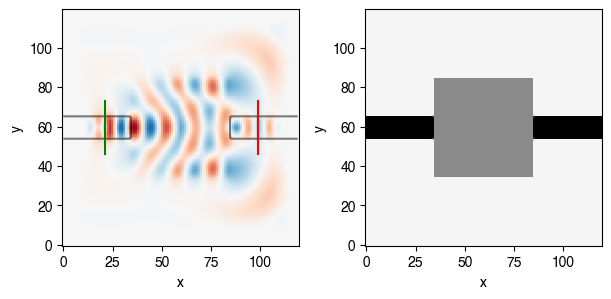

Epoch:   1/ 30 | Duration: 0.17 secs | Value: -2.520000e-04
Epoch:   2/ 30 | Duration: 0.21 secs | Value: -2.414685e-04
Epoch:   3/ 30 | Duration: 0.17 secs | Value: -2.296317e-04
Epoch:   4/ 30 | Duration: 0.17 secs | Value: -2.183310e-04
Epoch:   5/ 30 | Duration: 0.16 secs | Value: -2.069994e-04
Epoch:   6/ 30 | Duration: 0.17 secs | Value: -1.959334e-04
Epoch:   7/ 30 | Duration: 0.18 secs | Value: -1.847681e-04
Epoch:   8/ 30 | Duration: 0.17 secs | Value: -1.735493e-04
Epoch:   9/ 30 | Duration: 0.16 secs | Value: -1.624081e-04
Epoch:  10/ 30 | Duration: 0.17 secs | Value: -1.512636e-04
Epoch:  11/ 30 | Duration: 0.16 secs | Value: -1.401140e-04
Epoch:  12/ 30 | Duration: 0.16 secs | Value: -1.289973e-04
Epoch:  13/ 30 | Duration: 0.16 secs | Value: -1.178413e-04
Epoch:  14/ 30 | Duration: 0.17 secs | Value: -1.067153e-04
Epoch:  15/ 30 | Duration: 0.16 secs | Value: -9.558590e-05
Epoch:  16/ 30 | Duration: 0.17 secs | Value: -8.442228e-05
Epoch:  17/ 30 | Duration: 0.16 secs | V

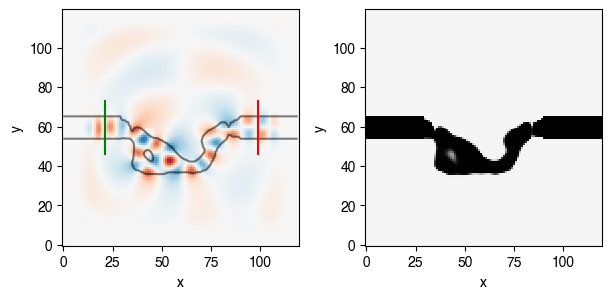

In [12]:
# Initialize the parametrization rho and the design region
rho, bg_rho, design_region, input_slice, output_slice = \
    init_domain(Nx, Ny, Npml, space=space, wg_width=wg_width, space_slice=space_slice)

# Compute the permittivity from rho_init, including blurring and projection
epsr_init = epsr_parameterization(rho, bg_rho, design_region, \
                                  radius=blur_radius, blur_applications=blur_applications, beta=beta, eta=eta)

# Setup source
source = insert_mode(omega, dl, input_slice.x, input_slice.y, epsr_init, m=1)

# Setup probe
probe = insert_mode(omega, dl, output_slice.x, output_slice.y, epsr_init, m=2)

# Simulate initial device
simulation, ax = viz_sim(epsr_init)

# Run optimization
objective_jac = jacobian(objective, mode='reverse')
(rho_optimum, loss) = adam_optimize(objective, rho.flatten(), objective_jac,
                         Nsteps=Nsteps, direction='max', step_size=step_size)

# Simulate optimal device
rho_optimum = rho_optimum.reshape((Nx, Ny))
epsr_init = epsr_parameterization(rho_optimum, bg_rho, design_region, \
                                  radius=blur_radius, blur_applications=blur_applications, beta=beta, eta=eta)
simulation, ax = viz_sim(epsr_init)

## Visualizing the parameterization steps

Finally, we can take a look what each step of our parameterization actually looks like. Below we visualize the raw density distribution, the blurred density distribution, and finally, the projected device density.

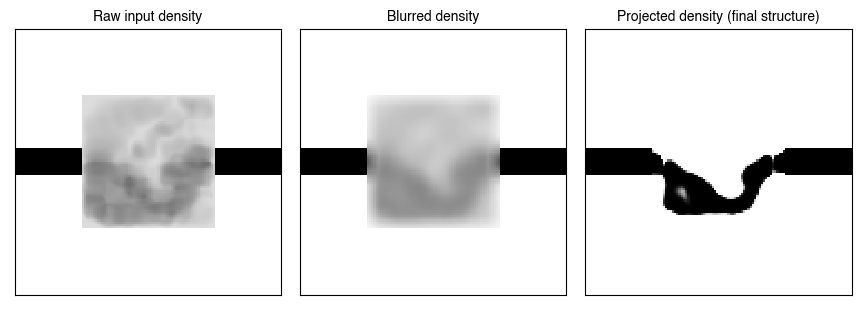

In [13]:
fig, axs = plt.subplots(1,3,constrained_layout=True,sharex=True,sharey=True, figsize=(8.5,3))
Z = mask_combine_rho(rho_optimum, bg_rho, design_region)
ceviche.viz.abs(Z, cmap='Greys', ax=axs[0])
axs[0].set_xlabel('')
axs[0].set_xticks([])
axs[0].set_ylabel('')
axs[0].set_yticks([])
axs[0].set_title('Raw input density')

Z = mask_combine_rho(rho_optimum, bg_rho, design_region)
Z = operator_blur(Z, radius=blur_radius, N=blur_applications)
# Z = operator_proj(Z, beta=beta, eta=eta)
Z = mask_combine_rho(Z, bg_rho, design_region)
ceviche.viz.abs(Z, cmap='Greys', ax=axs[1])
axs[1].set_xlabel('')
axs[1].set_ylabel('')
axs[1].set_title('Blurred density')

Z = rho_optimum
Z = mask_combine_rho(Z, bg_rho, design_region)
Z = operator_blur(Z, radius=blur_radius, N=blur_applications)
Z = operator_proj(Z, beta=beta, eta=eta)
Z = mask_combine_rho(Z, bg_rho, design_region)
ceviche.viz.abs(Z, cmap='Greys', ax=axs[2])
axs[2].set_xlabel('')
axs[2].set_ylabel('')
axs[2].set_title('Projected density (final structure)');